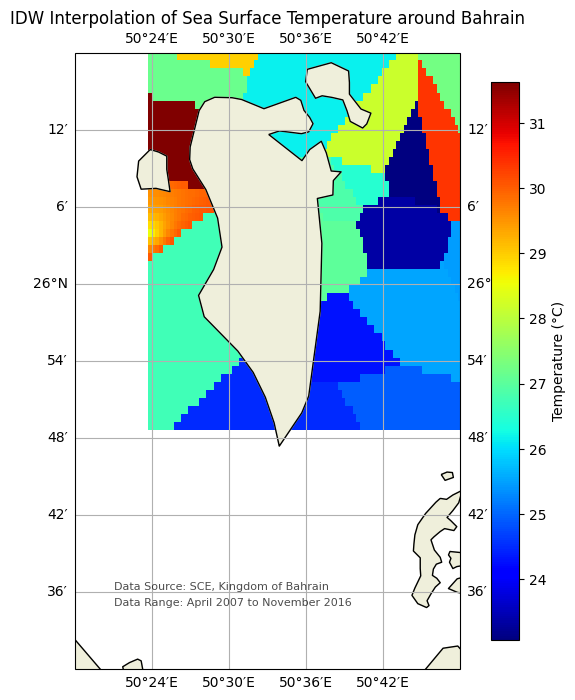

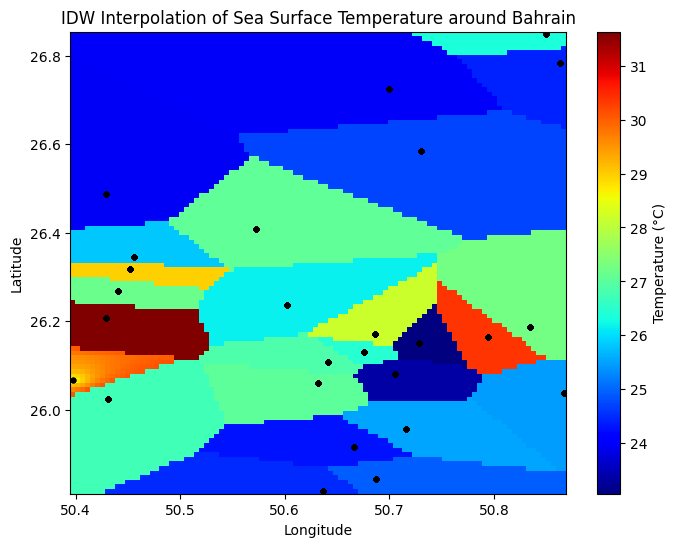

In [6]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the climate data
climate_data_path = 'marine 2007 - 2016 may 2017(1).csv'
climate_data = pd.read_csv(climate_data_path, encoding='ISO-8859-1')

# Load the geographic location data
geo_locations_path = 'Bahrain Climate Data - Geo Locations - Sheet2.csv'
geo_locations_data = pd.read_csv(geo_locations_path)

# Merge the climate data with the geo location data
data_merged = climate_data.merge(geo_locations_data, how='left', left_on='locations', right_on='Location')

# Correct the merge operation to use the right column names
# Assuming 'locations' is in the climate data and 'Location' is in the geo locations data
data_merged = climate_data.merge(geo_locations_data, how='left', left_on='locations', right_on='Location')

# Function to perform Inverse Distance Weighting (IDW) interpolation
def idw_interpolation(x, y, z, xi, yi, power=1):
    # Create a tree for fast spatial searching
    tree = cKDTree(np.vstack((x, y)).T)
    # Find the distances to the nearest neighbors and their indices
    distances, indices = tree.query(np.vstack((xi.ravel(), yi.ravel())).T, k=6)
    # Inverse distance weighting
    weights = 1 / distances**power
    # Handle infinities if we have zero distance
    weights[np.isinf(weights)] = 1.0
    # Calculate the interpolated values
    zi = np.sum(weights * z[indices], axis=1) / np.sum(weights, axis=1)
    zi = zi.reshape(xi.shape)
    return zi

# Clean the data
data_merged['Temperature oC'] = pd.to_numeric(data_merged['Temperature oC'], errors='coerce')
data_merged.dropna(subset=['Temperature oC', 'Longitude_dd', 'Latitude_dd'], inplace=True)

# Get the coordinates and values, ensuring they are finite
x = data_merged['Longitude_dd'].values
y = data_merged['Latitude_dd'].values
z = data_merged['Temperature oC'].values 

# Define the grid over which to interpolate
# Make sure this grid covers your area of interest accurately
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
xi, yi = np.meshgrid(xi, yi)

# Perform IDW interpolation
zi = idw_interpolation(x, y, z, xi, yi)

# Define the geographic extent of interest around Bahrain
extent = [50.3, 50.8, 25.5, 26.3]  # min longitude, max longitude, min latitude, max latitude

fig = plt.figure(figsize=(10, 8))

# Define the projection and extent (make sure this covers your area of interest)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Create a feature for land that will be used as a mask
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor=cfeature.COLORS['land'])

# Add land mask to the plot - this will cover land areas
ax.add_feature(land_feature, zorder=1)

# Plot the IDW interpolation results - ensure the zorder is lower than land mask
# This way the land mask will be plotted on top of the sea surface temperatures
temperature_plot = ax.pcolormesh(xi, yi, zi, shading='auto', cmap='jet', transform=ccrs.PlateCarree(), zorder=0)


# Add color bar
cbar = plt.colorbar(temperature_plot, orientation='vertical', fraction=0.036, pad=0.04)
cbar.set_label('Temperature (°C)')

# Add gridlines, coastlines, and features
ax.coastlines(resolution='10m', color='black', linewidth=1)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

plt.title('IDW Interpolation of Sea Surface Temperature around Bahrain')
plt.text(50.35, 25.6, 'Data Source: SCE, Kingdom of Bahrain', fontsize=8, color='black', ha='left', va='bottom', alpha=0.7)
plt.text(50.35, 25.58, 'Data Range: April 2007 to November 2016', fontsize=8, color='black', ha='left', va='bottom', alpha=0.7)
plt.show()

# Define the grid over which to interpolate
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
xi, yi = np.meshgrid(xi, yi)

# Perform IDW interpolation
zi = idw_interpolation(x, y, z, xi, yi)

# Plotting the interpolated data
# add a text underneath to state the source of the data
plt.figure(figsize=(8, 6))
plt.pcolormesh(xi, yi, zi, shading='auto', cmap='jet')
plt.colorbar(label='Temperature (°C)')
plt.scatter(x, y, c='black', s=10)  # Plot the location of the original data points
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('IDW Interpolation of Sea Surface Temperature around Bahrain')
plt.show()